### Importing Datasets

In [2]:
import pandas as pd

# Load datasets
april_may_data = pd.read_csv("D:\Fitness_Classes_Data (1)\Fitness Classes Data\Classes April-May 2018.csv")
june_data = pd.read_csv("D:\Fitness_Classes_Data (1)\Fitness Classes Data\Classes June 2018.csv")

# Combine datasets
combined_data = pd.concat([april_may_data, june_data], ignore_index=True)

# Display combined dataset info
print(combined_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ActivitySiteID                           3289 non-null   object 
 1   ActivityDescription                      3289 non-null   object 
 2   BookingEndDateTime (Month / Day / Year)  3289 non-null   object 
 3   BookingStartTime                         3289 non-null   object 
 4   MaxBookees                               3289 non-null   int64  
 5   Number Booked                            3289 non-null   int64  
 6   Price (INR)                              3271 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 180.0+ KB
None


### Preprocessing

In [4]:
# Data Cleaning
# Correct column name for 'BookingEndDateTime'
combined_data.rename(columns={
    'BookingEndDateTime (Month / Day / Year)': 'BookingEndDateTime'
}, inplace=True)

# Fill missing 'Price (INR)' values with median
combined_data['Price (INR)'] = combined_data['Price (INR)'].fillna(combined_data['Price (INR)'].median())

# Ensure 'BookingStartTime' and 'BookingEndDateTime' are datetime, handle errors
combined_data['BookingStartTime'] = pd.to_datetime(combined_data['BookingStartTime'], errors='coerce')
combined_data['BookingEndDateTime'] = pd.to_datetime(combined_data['BookingEndDateTime'], errors='coerce')

# Drop rows where 'BookingStartTime' or 'BookingEndDateTime' is invalid (NaT)
combined_data.dropna(subset=['BookingStartTime', 'BookingEndDateTime'], inplace=True)

### Feature Engineering

In [5]:
# Extract relevant features from 'BookingStartTime' and 'BookingEndDateTime'
combined_data['Month'] = combined_data['BookingStartTime'].dt.month
combined_data['DayOfWeek'] = combined_data['BookingStartTime'].dt.day_name()
combined_data['StartHour'] = combined_data['BookingStartTime'].dt.hour

# Ensure 'Number Booked' and 'MaxBookees' are numeric
combined_data['Number Booked'] = pd.to_numeric(combined_data['Number Booked'], errors='coerce')
combined_data['MaxBookees'] = pd.to_numeric(combined_data['MaxBookees'], errors='coerce')

# Calculate 'DemandRatio', handle division by zero or invalid values
combined_data['DemandRatio'] = combined_data['Number Booked'] / combined_data['MaxBookees']
combined_data['DemandRatio'].replace([float('inf'), -float('inf'), float('nan')], 0, inplace=True)

# Calculate 'ClassDuration' in minutes
combined_data['ClassDuration'] = (combined_data['BookingEndDateTime'] - combined_data['BookingStartTime']).dt.total_seconds() / 60

### Save and processed dataset

In [6]:
# Save the processed dataset
combined_data.to_csv("processed_fitness_data.csv", index=False)

# Confirm that the file has been saved
print("Processed data saved to 'processed_fitness_data.csv'")

Processed data saved to 'processed_fitness_data.csv'


### Export cleaned data as .xlsx

In [7]:
df = combined_data
df.to_excel('cleaned_data_final_VrushaliPatel.xlsx', index=False)

In [8]:
import os
print(os.getcwd())

C:\Users\VRUSHALI


In [9]:
df.to_excel(r'C:\Users\Vrushali\Documents\cleaned_data_final_VrushaliPatel.xlsx', index=False)

In [10]:
import os
print(os.listdir())

['.anaconda', '.android', '.bash_history', '.conda', '.condarc', '.continuum', '.emulator_console_auth_token', '.gitconfig', '.gradle', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.librarymanager', '.m2', '.matplotlib', '.templateengine', '.vscode', 'anaconda3', 'AndroidStudioProjects', 'AppData', 'Apple', 'Application Data', 'cleaned_data_final_ VrushaliPatel.xlsx', 'cleaned_data_final_VrushaliPatel.xlsx', 'Cookies', 'Data cleaning and preprocessing code_Vrushali Patel.ipynb', 'Data Type .ipynb', 'Documents', 'EDA.ipynb', 'Favorites', 'Identifiers & Keywords.ipynb', 'Links', 'Local Settings', 'Microsoft', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{09b5adac-b044-11ed-b66d-83dd40020272}.TM.blf', 'NTUSER.DAT{09b5adac-b044-11ed-b66d-83dd40020272}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{09b5adac-b044-11ed-b66d-83dd40020272}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'pandas

In [11]:
import pandas as pd

# Load processed data
data = pd.read_csv("processed_fitness_data.csv")

# General Overview
print("Summary of Price (INR):")
print(data['Price (INR)'].describe())

print("\nSummary of Demand Ratio:")
print(data['DemandRatio'].describe())

Summary of Price (INR):
count    3289.000000
mean     1850.778656
std       790.894827
min       499.000000
25%      1299.000000
50%      1499.000000
75%      2499.000000
max      3999.000000
Name: Price (INR), dtype: float64

Summary of Demand Ratio:
count    3289.000000
mean        0.571554
std         0.318444
min         0.016667
25%         0.342857
50%         0.550000
75%         0.800000
max         5.166667
Name: DemandRatio, dtype: float64


# Price Elasticity model

### Best price calculation

In [12]:
# Step 1: Base Price Calculation
# Calculate the median price for each ActivityDescription
base_prices = data.groupby('ActivityDescription')['Price (INR)'].median().reset_index()
base_prices.rename(columns={'Price (INR)': 'BasePrice'}, inplace=True)

# Merge the base prices with the original data
data = data.merge(base_prices, on='ActivityDescription', how='left')

# Display the base prices to verify
print(data[['ActivityDescription', 'BasePrice']].head())

       ActivityDescription  BasePrice
0  20-20-20  2.45pm-3.45pm      499.0
1  20-20-20  2.45pm-3.45pm      499.0
2  20-20-20  2.45pm-3.45pm      499.0
3  20-20-20  2.45pm-3.45pm      499.0
4  20-20-20  2.45pm-3.45pm      499.0


### Demand based pricing 

In [13]:
# Step 2: Demand-Based Pricing
def adjust_price_based_on_demand(row):
    # If demand_ratio > 0.8, increase price by 20%
    if row['DemandRatio'] > 0.8:
        return row['BasePrice'] * 1.20
    # If demand_ratio < 0.5, decrease price by 10%
    elif row['DemandRatio'] < 0.5:
        return row['BasePrice'] * 0.90
    # Otherwise, keep the base price
    else:
        return row['BasePrice']

# Apply the function to adjust the prices based on demand
data['Price (INR)'] = data.apply(adjust_price_based_on_demand, axis=1)

# Display the adjusted prices
print(data[['ActivityDescription', 'DemandRatio', 'Price (INR)']].head())

       ActivityDescription  DemandRatio  Price (INR)
0  20-20-20  2.45pm-3.45pm         0.48        449.1
1  20-20-20  2.45pm-3.45pm         0.60        499.0
2  20-20-20  2.45pm-3.45pm         0.56        499.0
3  20-20-20  2.45pm-3.45pm         0.36        449.1
4  20-20-20  2.45pm-3.45pm         0.28        449.1


### Time based pricing 

In [14]:
# Step 3: Time-Based Pricing
def adjust_price_based_on_time(row):
    # Extract the hour from StartHour
    hour = row['StartHour']

    # Increase prices during peak hours (6 AM - 9 AM and 6 PM - 9 PM)
    if (hour >= 6 and hour < 9) or (hour >= 18 and hour < 21):
        return row['Price (INR)'] * 1.15  # Increase by 15% during peak hours
    # Offer discounts during off-peak hours (midnight to early morning)
    elif hour < 6 or hour >= 21:
        return row['Price (INR)'] * 0.90  # Decrease by 10% during off-peak hours
    # Otherwise, no change
    else:
        return row['Price (INR)']

# Apply the time-based adjustment
data['Price (INR)'] = data.apply(adjust_price_based_on_time, axis=1)

# Display the adjusted prices
print(data[['ActivityDescription', 'StartHour', 'Price (INR)']].head())

       ActivityDescription  StartHour  Price (INR)
0  20-20-20  2.45pm-3.45pm         14        449.1
1  20-20-20  2.45pm-3.45pm         14        499.0
2  20-20-20  2.45pm-3.45pm         14        499.0
3  20-20-20  2.45pm-3.45pm         14        449.1
4  20-20-20  2.45pm-3.45pm         14        449.1


### Location-Based Pricing

In [15]:
# Step 4: Location-Based Pricing
# Calculate average demand per location (ActivitySiteID)
average_demand_per_site = data.groupby('ActivitySiteID')['DemandRatio'].mean().reset_index()
average_demand_per_site.rename(columns={'DemandRatio': 'AvgDemand'}, inplace=True)

# Merge the average demand per site with the original data
data = data.merge(average_demand_per_site, on='ActivitySiteID', how='left')

# Adjust price based on location demand
def adjust_price_based_on_location(row):
    if row['AvgDemand'] > 0.7:  # Popular location (high demand)
        return row['Price (INR)'] * 1.10  # Increase price by 10%
    elif row['AvgDemand'] < 0.3:  # Underutilized location (low demand)
        return row['Price (INR)'] * 0.85  # Decrease price by 15%
    else:
        return row['Price (INR)']

# Apply the location-based pricing adjustment
data['Price (INR)'] = data.apply(adjust_price_based_on_location, axis=1)

# Display the final adjusted prices
print(data[['ActivityDescription', 'ActivitySiteID', 'Price (INR)']].head())

       ActivityDescription ActivitySiteID  Price (INR)
0  20-20-20  2.45pm-3.45pm            HXP        449.1
1  20-20-20  2.45pm-3.45pm            HXP        499.0
2  20-20-20  2.45pm-3.45pm            HXP        499.0
3  20-20-20  2.45pm-3.45pm            HXP        449.1
4  20-20-20  2.45pm-3.45pm            HXP        449.1


# Demand Forecating models

### Demand Trends

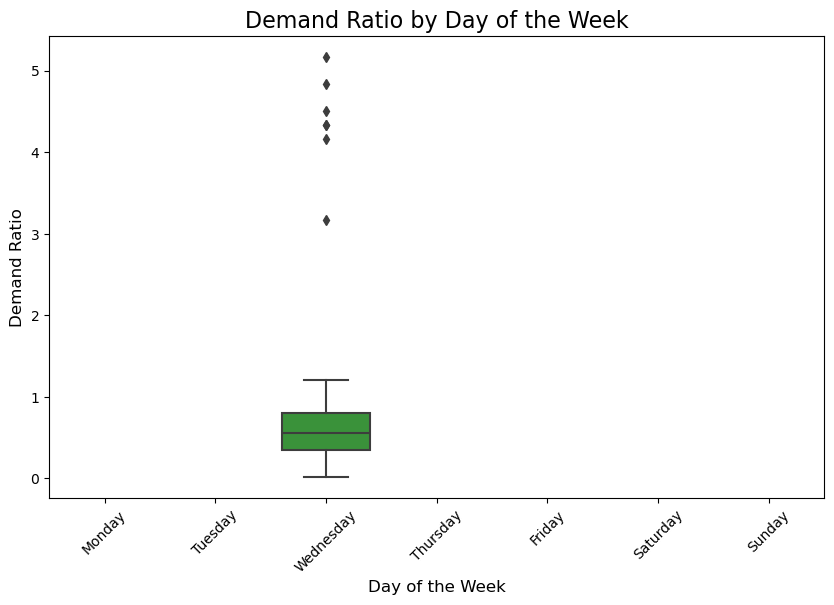

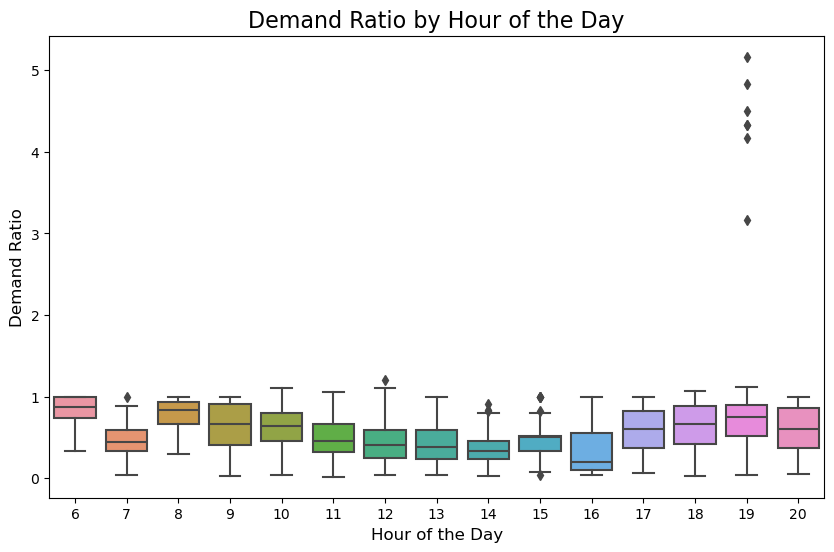

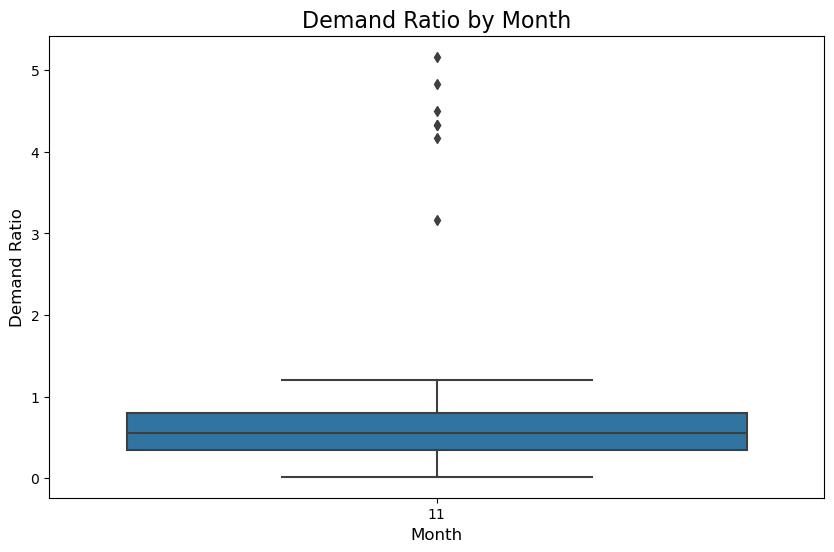

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Demand Trends by Day of the Week
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='DemandRatio', data=data, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Demand Ratio by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Demand Ratio", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Demand Trends by Hour
plt.figure(figsize=(10, 6))
sns.boxplot(x='StartHour', y='DemandRatio', data=data)
plt.title("Demand Ratio by Hour of the Day", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Demand Ratio", fontsize=12)
plt.show()

# Demand Trends by Month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='DemandRatio', data=data)
plt.title("Demand Ratio by Month", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Demand Ratio", fontsize=12)
plt.show()

# Pricing vs Demand and Trends by Location


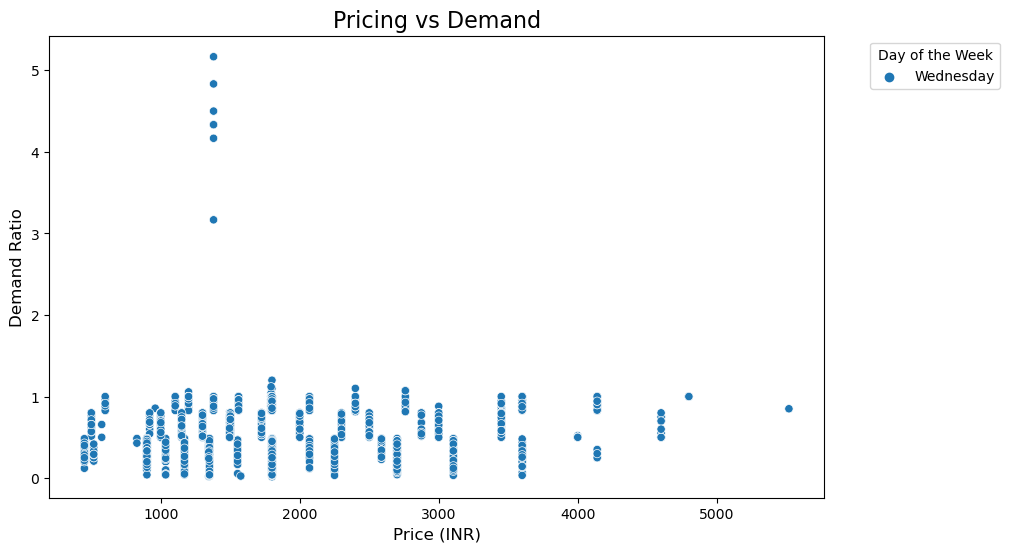

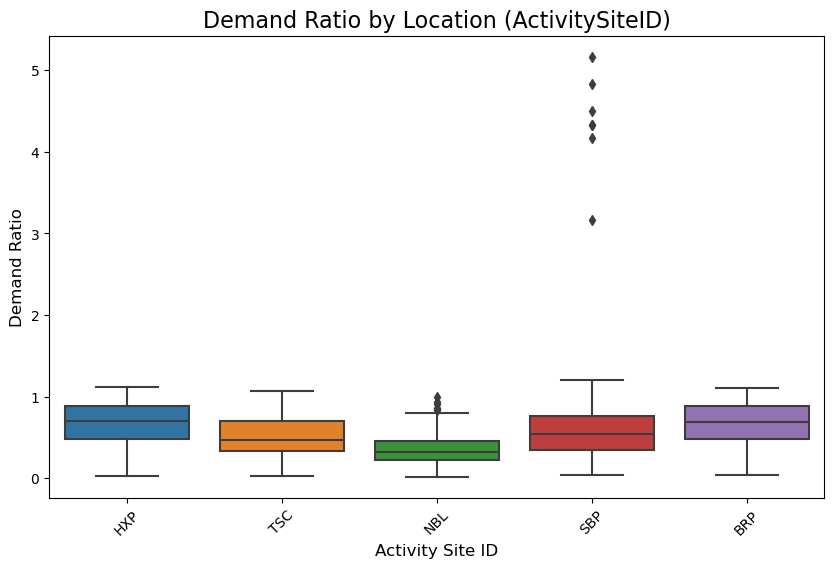

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pricing vs Demand
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price (INR)', y='DemandRatio', hue='DayOfWeek', data=data)
plt.title("Pricing vs Demand", fontsize=16)
plt.xlabel("Price (INR)", fontsize=12)
plt.ylabel("Demand Ratio", fontsize=12)
plt.legend(title="Day of the Week", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Demand Trends by Location (ActivitySiteID)
plt.figure(figsize=(10, 6))
sns.boxplot(x='ActivitySiteID', y='DemandRatio', data=data)
plt.title("Demand Ratio by Location (ActivitySiteID)", fontsize=16)
plt.xlabel("Activity Site ID", fontsize=12)
plt.ylabel("Demand Ratio", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Dynamic Pricing Algorithm

In [18]:
# Step 1: Define Dynamic Pricing Function
def apply_dynamic_pricing(row):
    # Base Price Calculation
    base_price = row['BasePrice']

    # Demand-Based Pricing Adjustment
    if row['DemandRatio'] > 0.8:
        price = base_price * 1.20  # Increase by 20%
    elif row['DemandRatio'] < 0.5:
        price = base_price * 0.90  # Decrease by 10%
    else:
        price = base_price  # No change for moderate demand

    # Time-Based Pricing Adjustment
    hour = row['StartHour']
    if (hour >= 6 and hour < 9) or (hour >= 18 and hour < 21):  # Peak hours (6-9 AM, 6-9 PM)
        price *= 1.15  # Increase by 15% during peak hours
    elif hour < 6 or hour >= 21:  # Off-peak hours (before 6 AM and after 9 PM)
        price *= 0.90  # Decrease by 10% during off-peak hours

    # Location-Based Pricing Adjustment
    if row['AvgDemand'] > 0.7:  # Popular location (high demand)
        price *= 1.10  # Increase price by 10%
    elif row['AvgDemand'] < 0.3:  # Underutilized location (low demand)
        price *= 0.85  # Decrease price by 15%

    return price

### Apply Dynamic Pricing to Dataset

In [19]:
# Step 2: Apply Dynamic Pricing to Dataset
# Apply dynamic pricing function to each row in the dataset
data['DynamicPrice (INR)'] = data.apply(apply_dynamic_pricing, axis=1)

# Display the first few rows to verify the changes
print(data[['ActivityDescription', 'ActivitySiteID', 'DemandRatio', 'StartHour', 'Price (INR)', 'DynamicPrice (INR)']].head())

       ActivityDescription ActivitySiteID  DemandRatio  StartHour  \
0  20-20-20  2.45pm-3.45pm            HXP         0.48         14   
1  20-20-20  2.45pm-3.45pm            HXP         0.60         14   
2  20-20-20  2.45pm-3.45pm            HXP         0.56         14   
3  20-20-20  2.45pm-3.45pm            HXP         0.36         14   
4  20-20-20  2.45pm-3.45pm            HXP         0.28         14   

   Price (INR)  DynamicPrice (INR)  
0        449.1               449.1  
1        499.0               499.0  
2        499.0               499.0  
3        449.1               449.1  
4        449.1               449.1  


### Automate the Pricing Updates and Save Processed Data

In [20]:
# Step 3: Automate the Pricing Updates and Save Processed Data
# Save the dataset with dynamic pricing applied
data.to_csv("dynamic_pricing_fitness_data.csv", index=False)

# Notify that the file has been saved
print("Dynamic pricing applied and saved to 'dynamic_pricing_fitness_data.csv'.")

Dynamic pricing applied and saved to 'dynamic_pricing_fitness_data.csv'.
